# Competition: [Regression with a Mohs Hardness Dataset](https://www.kaggle.com/competitions/playground-series-s3e25)

**Keywords**: #Regression #Playground #FeedforwardNeuralNetwork #FNN

## Introduction

In this project, our objective is to develop a robust predictive model for estimating the Mohs hardness of minerals based on their intrinsic properties. **Mohs hardness, a measure of a mineral's resistance to scratching,** is a crucial factor in various industrial applications, material science, and geology. Accurate prediction of Mohs hardness can expedite mineral classification and aid in material selection for specific purposes.

Motivated by the need for efficient and accurate mineral hardness prediction, we are leveraging advanced machine learning techniques, specifically TensorFlow/Keras neural networks. The project involves the creation of a regression model capable of understanding complex relationships within a dataset comprising 13 distinct mineral properties. The primary metric for model evaluation is the Median Absolute Error (MAE), ensuring a robust assessment of predictive accuracy.

By addressing this challenge, we aim to contribute to the field of mineralogy and material science, facilitating more precise hardness predictions and supporting advancements in various industries reliant on mineral properties. The small dataset of 10,000 data points, coupled with the incorporation of data augmentation and rigorous model tuning, underscores our commitment to developing a reliable and efficient predictive tool.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i0.wp.com/www.compoundchem.com/wp-content/uploads/2022/11/Mohs-Hardness-Scale.png?ssl=1")

## [Evaluation](www.kaggle.com/competitions/playground-series-s3e25/overview/evaluation)

Submissions are scored on the Median Absolute Error (MedAE). MedAE is defined as:

${\displaystyle \operatorname {MAD} =\operatorname {median} (|X_{i}-{\tilde {X}}|)}$

## [Data](https://www.kaggle.com/competitions/playground-series-s3e25/data)

The dataset for this competition (both train and test) was generated from a deep learning model trained on the Prediction of Mohs Hardness with Machine Learning dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

**Files**

* **train.csv** - the training dataset; Hardness is the continuous target
* **test.csv** - the test dataset; your objective is to predict the value of Hardness
* **sample_submission.csv** - a sample submission file in the correct format

**Input features:**

1. **id:** An identifier for each data point, likely used for tracking or indexing purposes.
2. **allelectrons_Total:** The total number of electrons in the atomic structure of the mineral.
3. **density_Total:** The total density of the mineral, representing the mass per unit volume.
4. **allelectrons_Average:** The average number of electrons in the atomic structure of the mineral.
5. **val_e_Average:** The average number of valence electrons in the atomic structure of the mineral.
6. **atomicweight_Average:** The average atomic weight of the elements in the mineral.
7. **ionenergy_Average:** The average ionization energy of the atoms in the mineral.
8. **el_neg_chi_Average:** The average electronegativity of the elements in the mineral, possibly using the Pauling electronegativity scale.
9. **R_vdw_element_Average:** The average van der Waals radius of the elements in the mineral.
10. **R_cov_element_Average:** The average covalent radius of the elements in the mineral.
11. **zaratio_Average:** The average ratio of the atomic number to the number of valence electrons for the elements in the mineral.
12. **density_Average:** The average density of the mineral.

**Target variable:**
1. **Hardness:** Mohs Hardness, a measure of the relative hardness of a mineral compared to other minerals. 

It is determined by the ability of a mineral to scratch another mineral. The scale is a qualitative ordinal scale with 10 being the hardest, represented by diamond, and 1 being the softest, represented by talc.

Here's a brief overview of the hardness scale:

1. **Talc:** Easily scratched by all other materials.
2. **Gypsum:** Can be scratched by a fingernail.
3. **Calcite:** Scratched by a copper coin.
4. **Fluorite:** Can scratch a penny but is easily scratched by a knife.
5. **Apatite:** Scratched by a knife but can scratch glass.
6. **Orthoclase Feldspar:** Can scratch glass.
7. **Quartz:** Scratches glass easily.
8. **Topaz:** Hard enough to scratch quartz.
9. **Corundum:** Can scratch topaz.
10. **Diamond:** The hardest mineral, capable of scratching all others.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e25/sample_submission.csv
/kaggle/input/playground-series-s3e25/train.csv
/kaggle/input/playground-series-s3e25/test.csv


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split

from sklearn.tree import export_text
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import median_absolute_error

import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization


import warnings
warnings.filterwarnings('ignore')

In [4]:
tf.keras.utils.set_random_seed(42)

In [5]:
debug = False
verbose_train = 0

In [6]:
df_train = pd.read_csv('/kaggle/input/playground-series-s3e25/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s3e25/test.csv')

#df_train.info()
display(df_train.tail().T)

#df_train.isnull().sum()
#df_train.nunique()
display(df_train.describe().loc[['std', '75%', 'max']])

,10402,10403,10404,10405,10406
id,10402.000000,10403.000000,10404.000000,10405.000000,10406.000000
allelectrons_Total,128.000000,30.000000,196.000000,38.000000,288.000000
density_Total,7.558488,1.743160,30.920000,1.553160,24.655328
allelectrons_Average,12.000000,10.000000,24.500000,12.666667,11.142857
val_e_Average,4.000000,5.333333,5.500000,4.666667,4.571429
atomicweight_Average,26.385218,20.766935,53.490297,26.621687,22.536126
ionenergy_Average,11.330440,14.163933,10.074300,11.290033,10.960357
el_neg_chi_Average,2.644000,3.090000,2.295000,2.743333,2.792143
R_vdw_element_Average,1.631000,1.556667,1.545000,1.756667,1.772857
R_cov_element_Average,0.892000,0.866667,1.120000,0.980000,0.940000


,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
std,3004.38646,224.123776,15.972877,10.468734,0.690864,26.012313,1.408276,0.334906,0.192481,0.180017,0.06308,1.936656,1.680525
75%,7804.50000,131.000000,16.676996,22.000000,4.800000,48.719500,11.670725,2.805000,1.800000,0.981667,0.49607,2.741550,6.000000
max,10406.00000,15300.000000,643.093804,67.000000,6.000000,167.400000,15.245810,3.443000,2.250000,1.615840,0.82599,10.970000,10.000000


In [7]:
def prepare_data(df, test=False):

    # Make the column names lower-case and uniform
    df.columns = df.columns.str.lower()

    # Drop id column
    df.drop('id', axis=1, inplace=True)
    
    
    # replace zeros with medians from dataframe
    for col in df.columns:
        df[col] = df[col].replace(0,df[col].median())
    
    # Feature engineering based on positive correlation
    df['volume_related'] = df['allelectrons_average'] * df['density_average'] * df['atomicweight_average']
    df['atomic_radius_combined'] = df['r_vdw_element_average'] + df['r_cov_element_average']

    # Feature engineering based on negative correlation
    df['atomic_interaction_1'] = df['r_cov_element_average'] * df['ionenergy_average']
    df['atomic_interaction_2'] = df['r_vdw_element_average'] * df['ionenergy_average']

    # Other feature engineering suggestions
    #df['density_volume_ratio'] = df['density_average'] / df['volume_related']
    df['electronegativity_difference'] = df['el_neg_chi_average'] - df['ionenergy_average']

    # Combined atomic descriptors
    df['combined_atomic_descriptor'] = df['val_e_average'] * df['atomicweight_average']

    # Polynomial features (example: squared term)
    df['density_squared'] = df['density_average'] ** 2
    
    # Logarithm transformation to reduce spread
    log_cols = ['density_total', 'volume_related', 'density_squared', 'allelectrons_total', 'allelectrons_average', 'density_average']
    for col in log_cols:
        df[col] = np.log1p(df[col])
    
    # Drop atomicweight_average column
    df.drop(['atomicweight_average', 'zaratio_average'], axis=1, inplace=True)
    
    
    return df

df_train = prepare_data(df_train)
df_test = prepare_data(df_test, test=True)

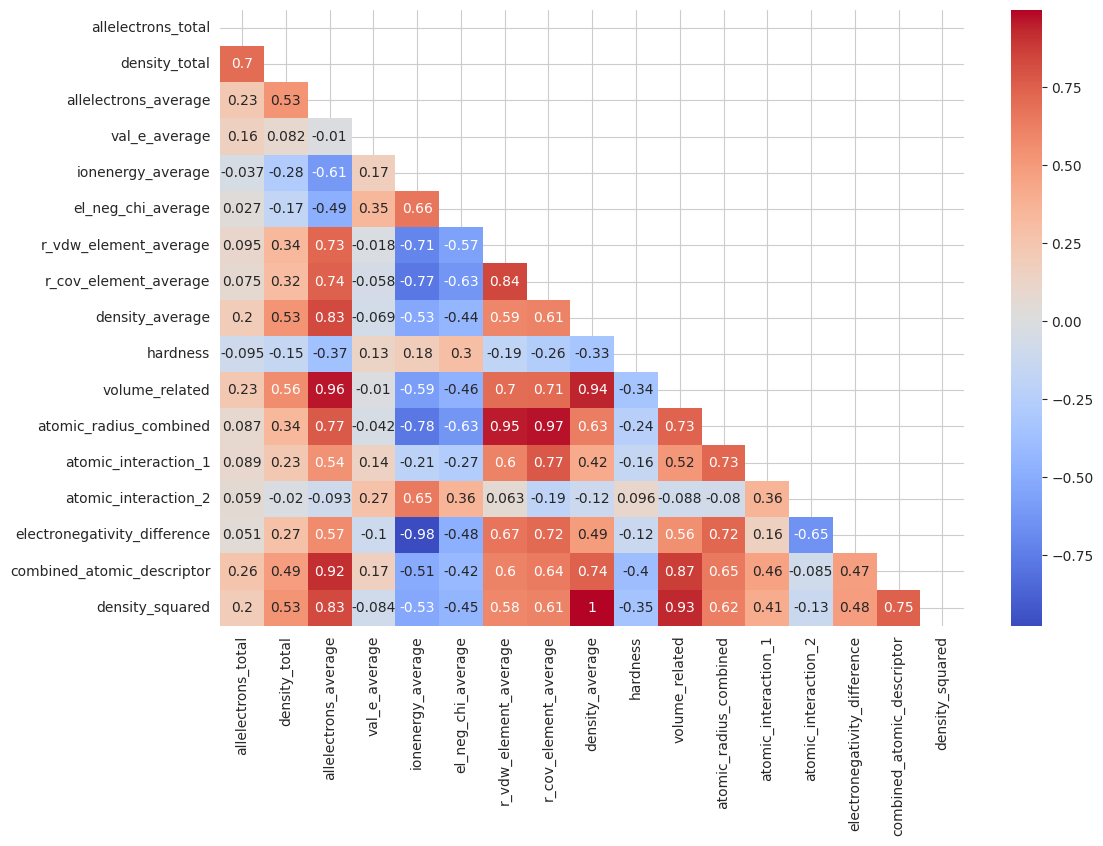

In [8]:
plt.figure(figsize=(12,8))
corr = df_train.corr().round(3)
sns.heatmap(corr,annot=True,cmap='coolwarm',mask=np.triu(corr))
plt.show()


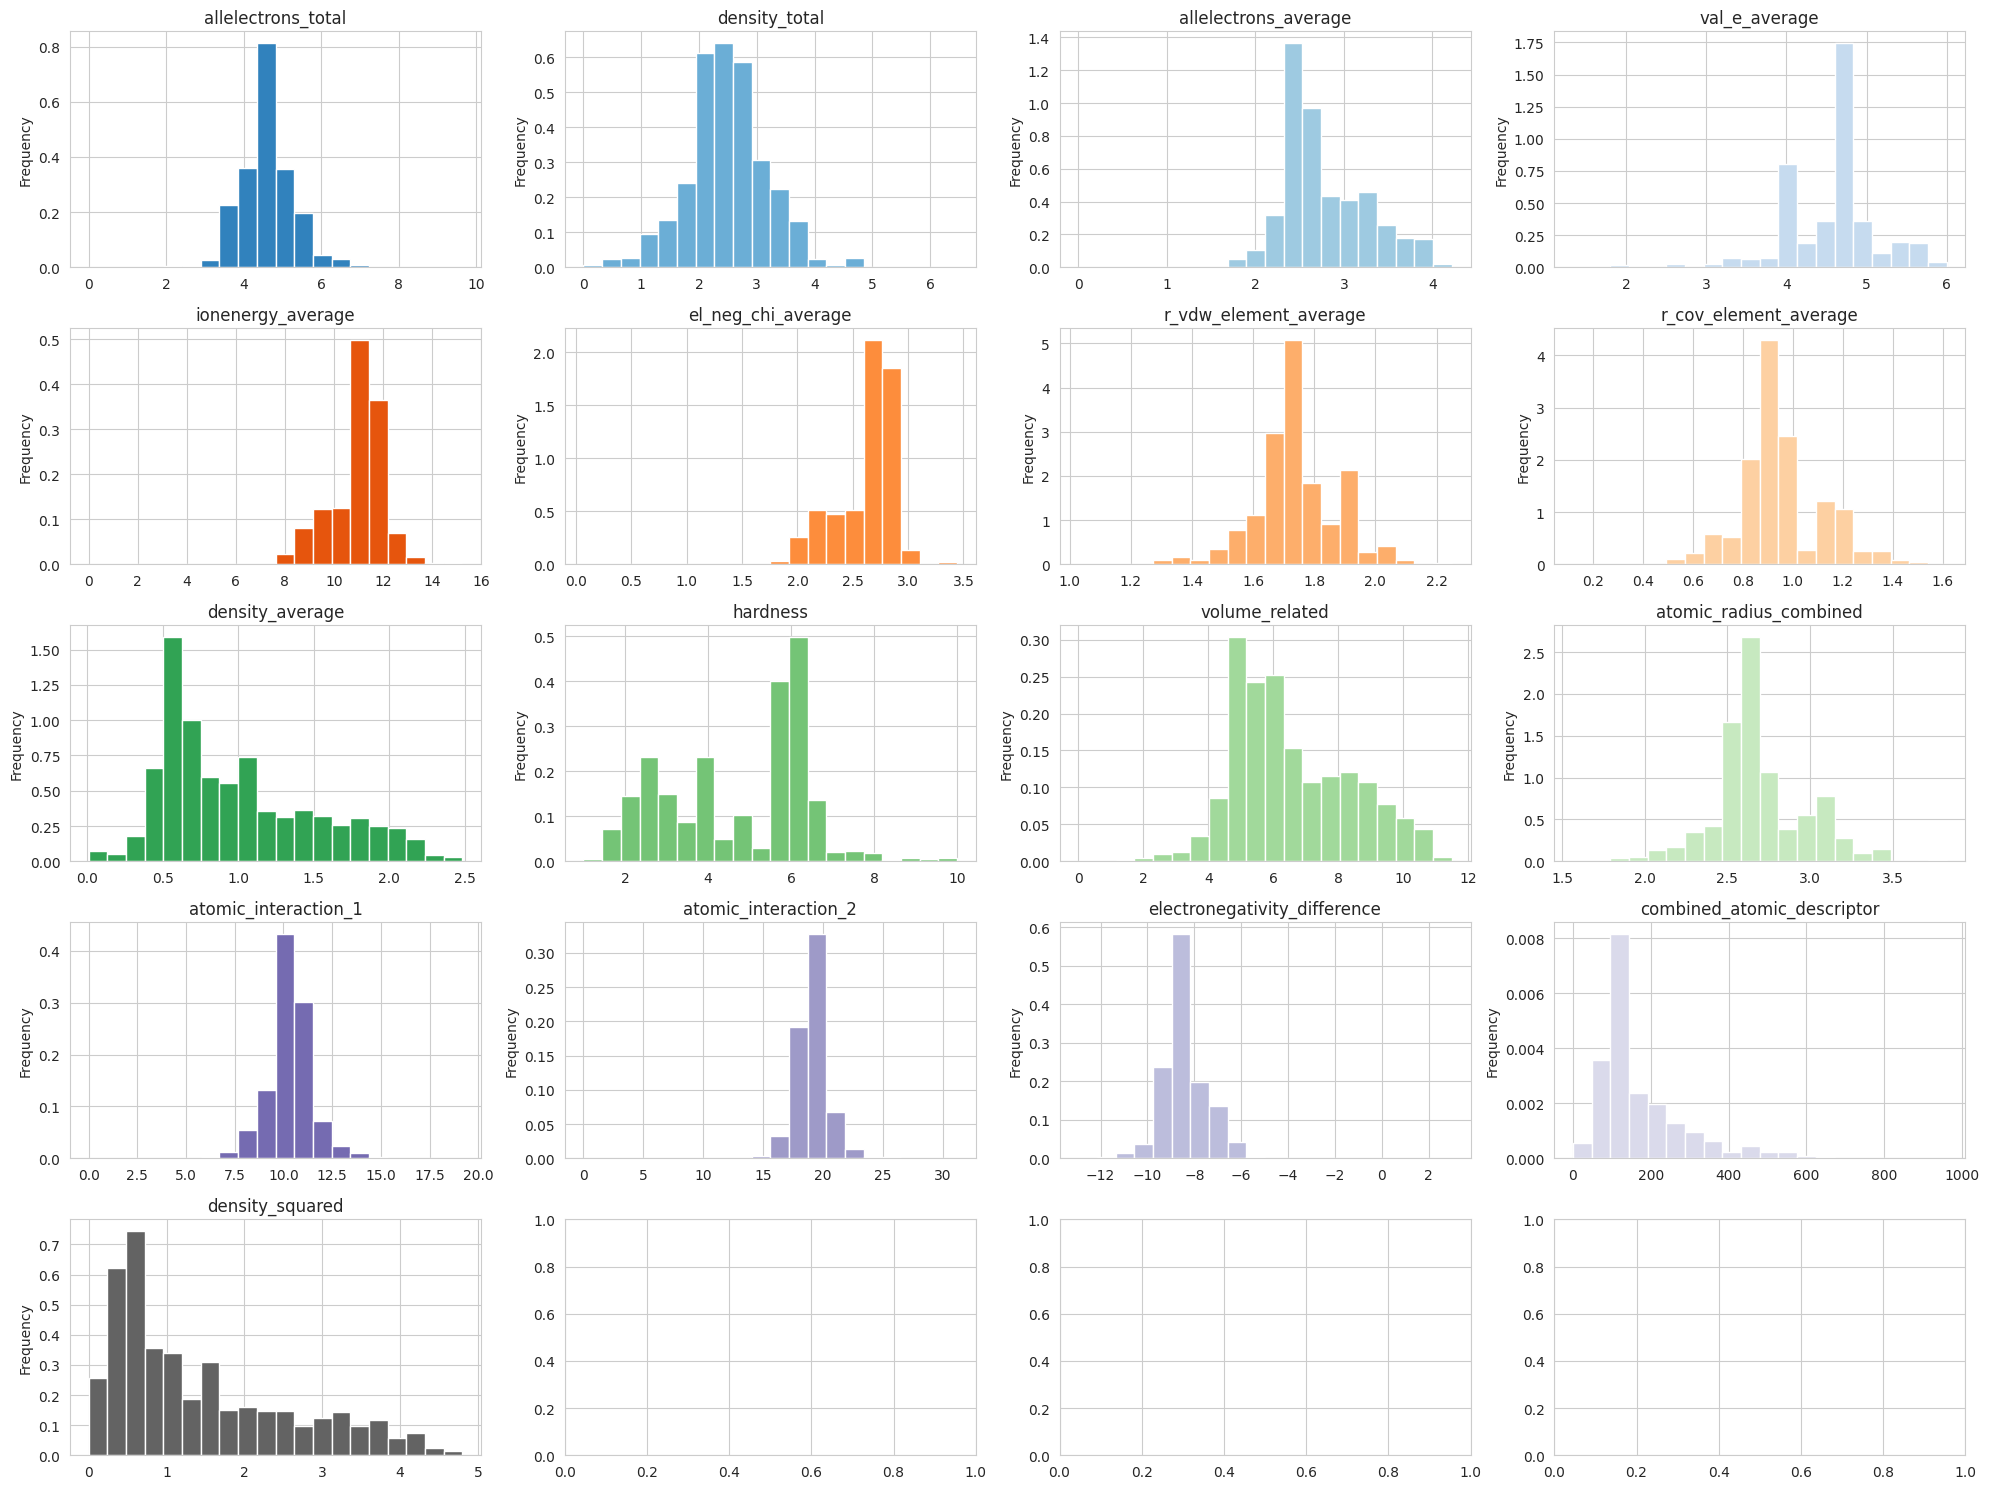

In [9]:
%matplotlib inline

cmap = plt.get_cmap("tab20c")
colors = cmap(range(df_train.columns.shape[0]))

fig, axs = plt.subplots(ncols=4, nrows=len(df_train.columns)//4 + 1, figsize=(20, int(3*(len(df_train.columns)//4 + 1))))
axs = axs.flatten()
    
for idx, col in enumerate(df_train.columns):
    df_train[col].plot.hist(ax=axs[idx], density=True, bins=20, color=colors[idx])
    axs[idx].set_title(col)
    
plt.tight_layout()

hardness                        1.000000
combined_atomic_descriptor      0.396852
allelectrons_average            0.367125
density_squared                 0.349950
volume_related                  0.340263
density_average                 0.329854
el_neg_chi_average              0.300047
r_cov_element_average           0.259984
atomic_radius_combined          0.237690
r_vdw_element_average           0.189418
ionenergy_average               0.180777
atomic_interaction_1            0.158152
density_total                   0.153007
val_e_average                   0.129214
electronegativity_difference    0.125108
atomic_interaction_2            0.095830
allelectrons_total              0.094945
dtype: float64

Text(0.5, 1.0, 'Correlation: Top 10 numerical features')

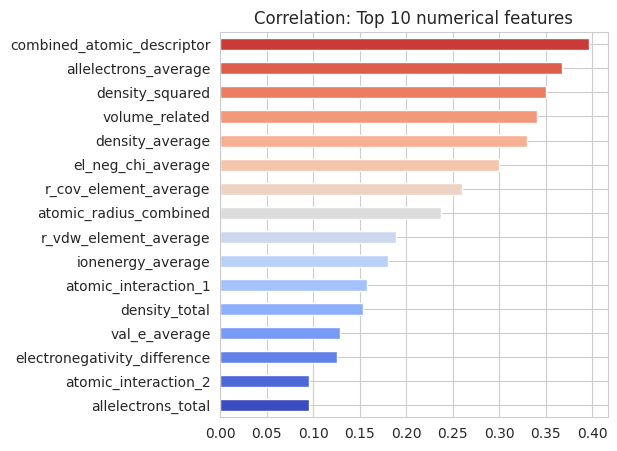

In [10]:
# Define the colormap
cmap = plt.get_cmap('coolwarm')

# Generate 10 evenly spaced values between 0 and 1
values = np.linspace(0, 1, len(df_train.columns))

# Get the corresponding colors from the colormap
colors = cmap(values)

corr = df_train.corrwith(df_train.hardness).abs().sort_values(ascending=False)
display(corr)

fig, ax = plt.subplots(figsize=(5,5))
corr[1:][::-1].plot.barh(ax=ax, cmap='tab20c', color=colors)
ax.set_title('Correlation: Top 10 numerical features')

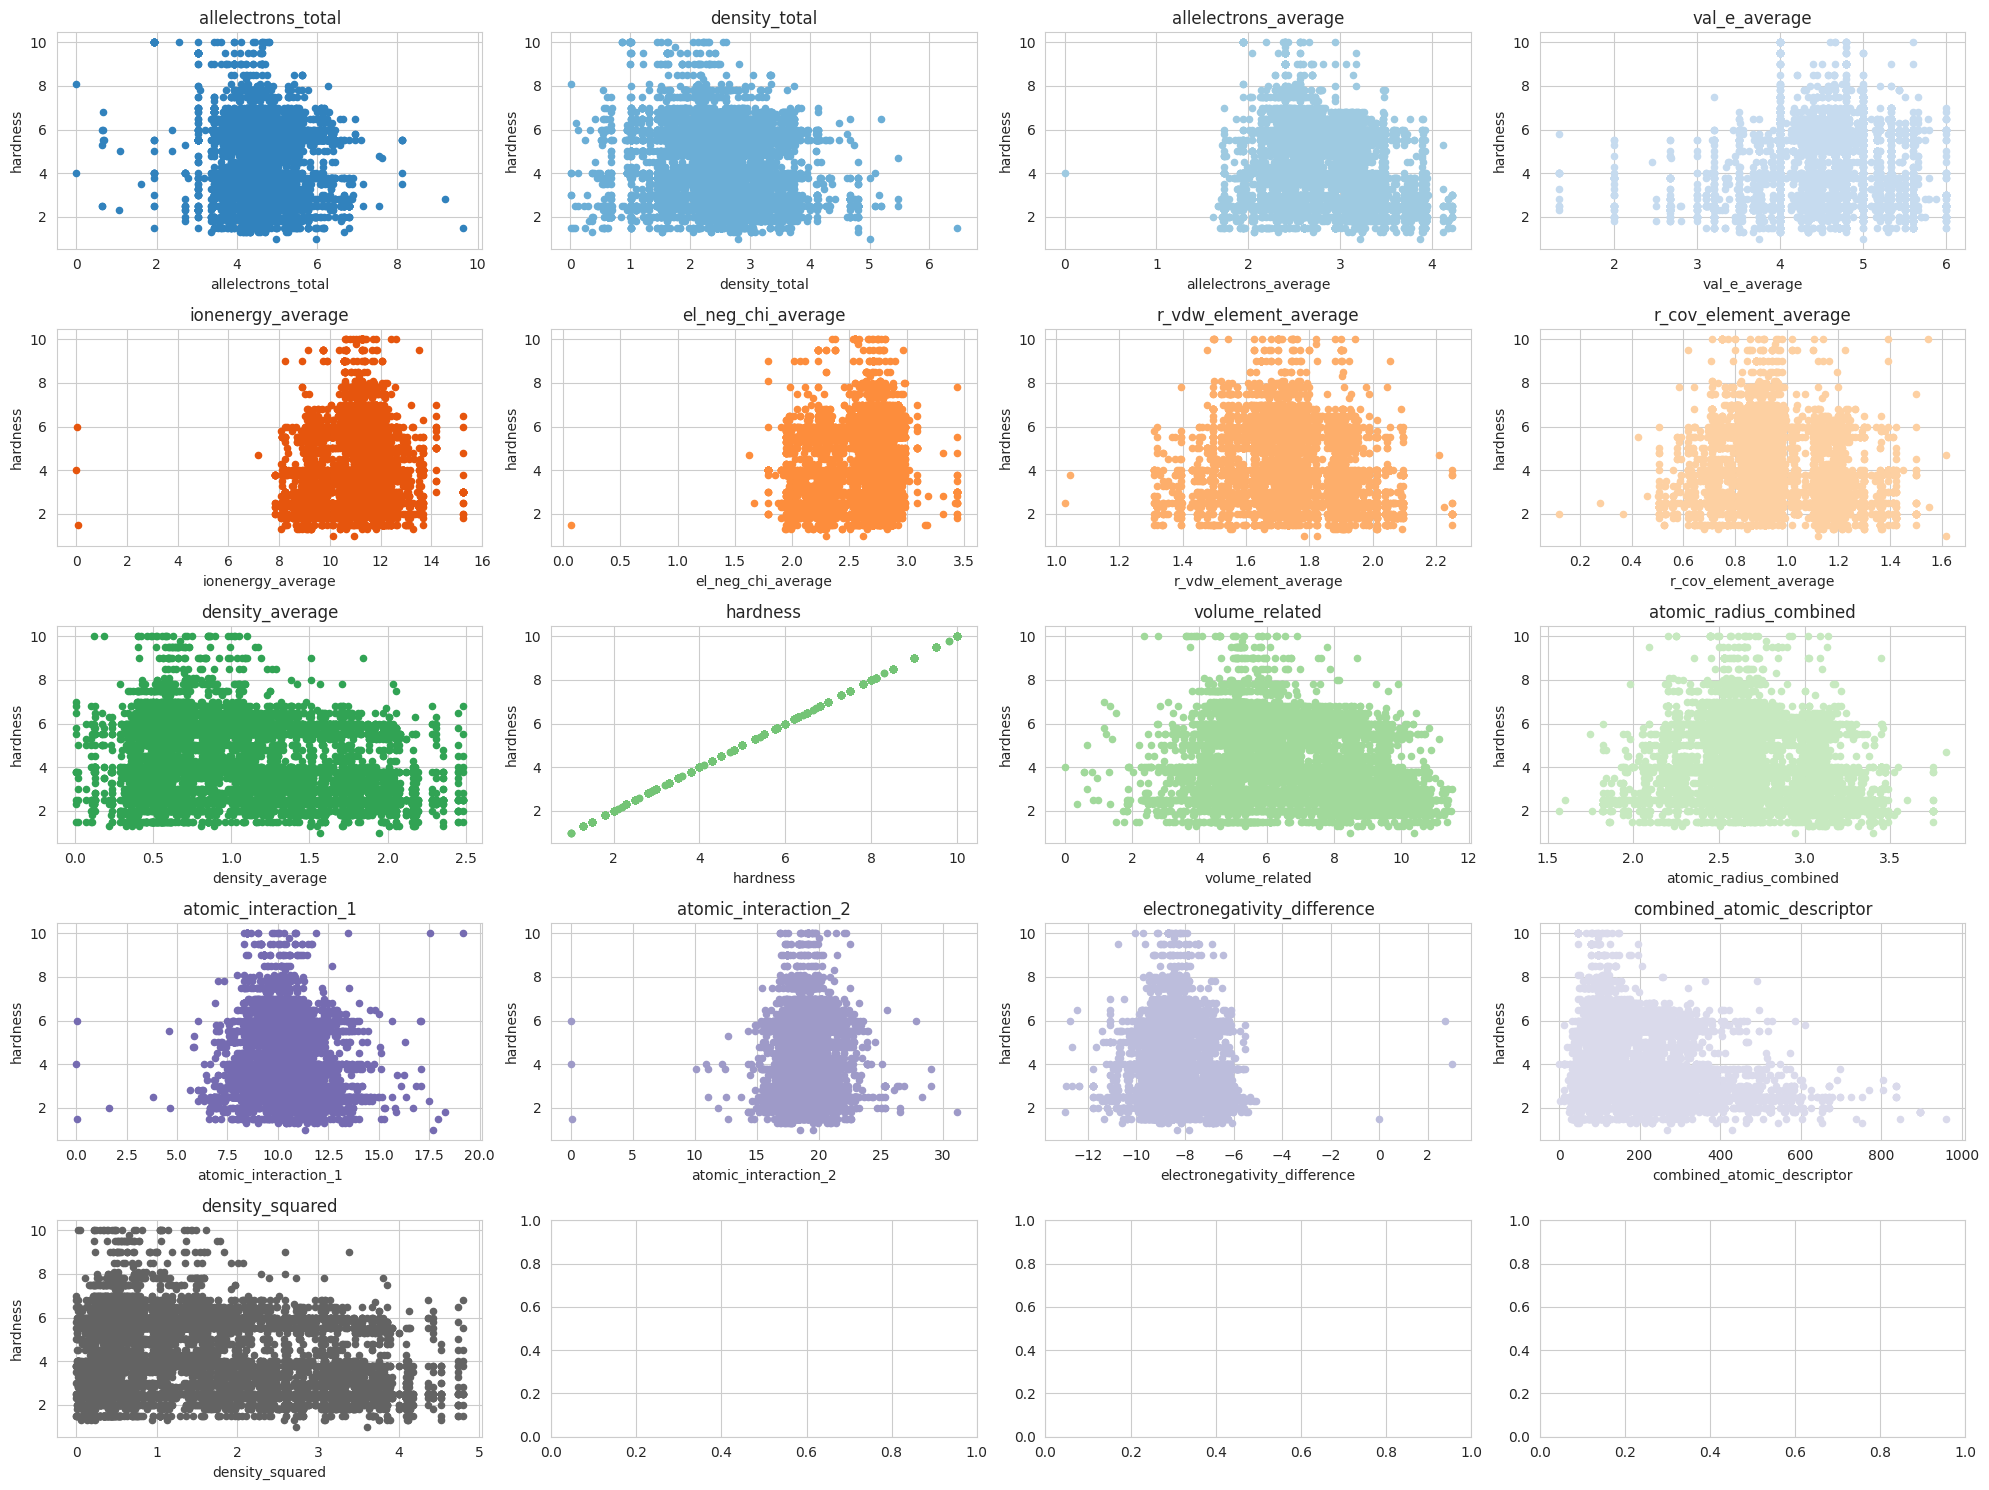

In [11]:
%matplotlib inline

cmap = plt.get_cmap("tab20c")
colors = cmap(range(df_train.columns.shape[0]))

fig, axs = plt.subplots(ncols=4, nrows=len(df_train.columns)//4 + 1, figsize=(20, int(3*(len(df_train.columns)//4 + 1))))
axs = axs.flatten()
    
for idx, col in enumerate(df_train.columns):
    df_train[[col, 'hardness']].plot.scatter(x=col, y='hardness', ax=axs[idx], color=colors[idx])
    axs[idx].set_title(col)
    
plt.tight_layout()

In [12]:
df_train, df_val = train_test_split(df_train, test_size=0.3, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_train = np.log1p(df_train.hardness.values)
y_val = np.log1p(df_val.hardness.values)

del df_train['hardness']
del df_val['hardness']


In [13]:
# encoding
scaler = MinMaxScaler()

X_train = scaler.fit_transform(df_train)
X_val = scaler.transform(df_val)
X_test = scaler.transform(df_test)

In [14]:
# Define the model
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[-1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

# Custom Median Absolute Error metric
def medae_keras(y_true, y_pred):
    y_true = tf.math.expm1(y_true)
    y_pred = tf.round(tf.math.expm1(y_pred))
    absolute_errors = tf.abs(y_true - y_pred)
    medae = tfp.stats.percentile(absolute_errors, 50.0, interpolation='linear')
    return medae

optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss = keras.losses.MeanAbsoluteError()

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=[medae_keras])

EPOCHS = 100
BATCH_SIZE = 32

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_medae_keras', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split=0.3, 
                    #callbacks=[early_stopping], 
                    verbose=verbose_train)

In [15]:
def plot_metrics(history):
  metrics = ['loss', 'medae_keras']
  plt.figure(figsize=(10,5))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(1,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0.18, 0.22])
    plt.legend()     

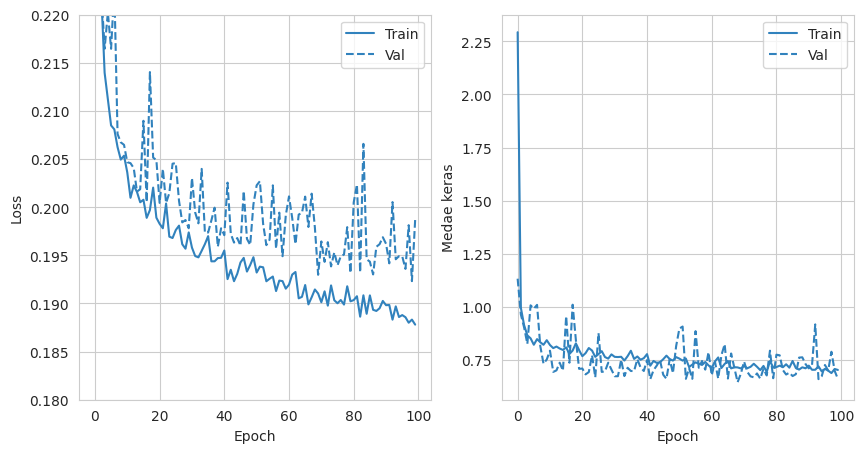

In [16]:
plot_metrics(history)


In [17]:
# Prediction
y_fit = np.expm1(model.predict(X_train, batch_size=BATCH_SIZE))
y_pred = np.expm1(model.predict(X_val, batch_size=BATCH_SIZE))

y_train = np.expm1(y_train)
y_val = np.expm1(y_val)

# Evaluation
print("Median Absolute Error (Training):", median_absolute_error(y_train, y_fit))
print("Median Absolute Error (Validation):", median_absolute_error(y_val, y_pred))

98/98 [==============================] - 0s 2ms/step
Median Absolute Error (Training): 0.6277527809143066
Median Absolute Error (Validation): 0.6247647285461424


In [18]:
if debug:
    y_submission_old = y_submission

In [19]:
submissions = pd.read_csv('/kaggle/input/playground-series-s3e25/sample_submission.csv')

y_submission = model.predict(X_test, batch_size=BATCH_SIZE)
y_submission = np.expm1(y_submission)
submissions['Hardness'] = y_submission.round(3)

submissions.to_csv('/kaggle/working/baseline.csv', index=False)

submissions.head()

217/217 [==============================] - 0s 1ms/step


,id,Hardness
0,10407,2.398
1,10408,4.121
2,10409,6.001
3,10410,5.586
4,10411,5.815


In [20]:
if debug:
    df_submission = pd.DataFrame({'id': submissions['id'],
                 'old': y_submission_old[:, 0],
                 'new': y_submission[:, 0]})
    df_submission['pct_x']  = 100*(df_submission.new - df_submission.old)/df_submission.old
    df_submission.drop(['old', 'new'], axis=1, inplace=True)
    
    df_test['id'] = submissions['id']
    df_submission = pd.merge(df_submission, df_test, on='id', how='left')
    #display(df_submission.sort_values('pct_x', ascending=False))
    
    # Define the colormap
    cmap = plt.get_cmap('coolwarm')

    # Generate 10 evenly spaced values between 0 and 1
    values = np.linspace(0, 1, len(df_submission.columns))

    # Get the corresponding colors from the colormap
    colors = cmap(values)

    corr = df_submission.corrwith(df_submission.pct_x).abs().sort_values(ascending=False)
    #display(corr)

    fig, ax = plt.subplots(figsize=(5,5))
    corr[1:][::-1].plot.barh(ax=ax, cmap='tab20c', color=colors)
    ax.set_title('Correlation: Top 10 numerical features')
    
    fig, axs = plt.subplots(ncols=5, nrows=4, figsize=(20, 20))
    axs = axs.flatten()

    for idx, col in enumerate(df_submission.columns[1:]):
        df_submission[[col, 'pct_x']].plot.scatter(x=col, y='pct_x', ax=axs[idx], color=colors[idx])
        axs[idx].set_title(col)

    plt.tight_layout()